In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
m = 9.1e-31
hbar = 1.054e-34
w = 1.602e-13 / hbar

m_c = tf.cast(m, tf.complex64)
hbar_c = tf.cast(m, tf.complex64)
w_c = tf.cast(w, tf.complex64)

x_min = -100e-9
x_max = 100e-9
t_min = 0
t_max = 50e-12

In [3]:
class PINN(tf.keras.Model):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = [tf.keras.layers.Dense(units, activation="tanh") for units in layers[:-1]]
    self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

  def call(self, inputs):
    x, t = inputs
    X = tf.stack([x, t], axis=1)

    for layer in self.hidden_layers:
      X = layer(X)

    output = self.output_layer(X)
    psi_real = output[:, 0:1]
    psi_imag = output[:, 1:2]
    return psi_real, psi_imag

In [4]:
layers = [2, 50, 50, 50, 50, 2]

In [5]:
n_collocation = 10000
n_initial = 2000
n_boundary = 2000

x_collocation = np.random.uniform(x_min, x_max, n_collocation)
t_collocation = np.random.uniform(t_min, t_max, n_collocation)

x_initial = np.random.uniform(x_min, x_max, n_initial)
t_initial = np.full(n_initial, t_min)

x_boundary = np.concatenate([np.full(n_boundary // 2, x_min), np.full(n_boundary // 2, x_max)])
t_boundary = np.random.uniform(t_min, t_max, n_boundary)

In [6]:
def normalize(value, min_value, max_value):
  return 2.0 * (value - min_value) / (max_value - min_value) - 1.0

In [7]:
x_collocation = normalize(x_collocation, x_min, x_max)
t_collocation = normalize(t_collocation, t_min, t_max)

x_initial = normalize(x_initial, x_min, x_max)
t_initial =  normalize(t_initial, t_min, t_max)

x_boundary = normalize(x_boundary, x_min, x_max)
t_boundary = normalize(t_boundary, t_min, t_max)

In [8]:
x_collocation_tf = tf.convert_to_tensor(x_collocation, dtype=tf.float64)
t_collocation_tf = tf.convert_to_tensor(t_collocation, dtype=tf.float64)

x_initial_tf = tf.convert_to_tensor(x_initial, dtype=tf.float64)
t_initial_tf = tf.convert_to_tensor(t_initial, dtype=tf.float64)

x_boundary_tf = tf.convert_to_tensor(x_boundary, dtype=tf.float64)
t_boundary_tf = tf.convert_to_tensor(t_boundary, dtype=tf.float64)

In [9]:
# x_collocation_tf = normalize(x_collocation_tf, x_min, x_max)
# t_collocation_tf = normalize(t_collocation_tf, t_min, t_max)

# x_initial_tf = normalize(x_initial_tf, x_min, x_max)
# t_initial_tf =  normalize(t_initial_tf, t_min, t_max)

# x_boundary_tf = normalize(x_boundary_tf, x_min, x_max)
# t_boundary_tf = normalize(t_boundary_tf, t_min, t_max)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [11]:
model = PINN(layers)

In [12]:
@tf.function
def loss_function():
  #pde loss
  with tf.GradientTape(persistent=True) as tape1:
    tape1.watch([x_collocation_tf, t_collocation_tf])

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_collocation_tf, t_collocation_tf])
      psi_real, psi_img = model((x_collocation_tf, t_collocation_tf))
      psi = tf.complex(psi_real, psi_img)

    d_psi_dx = tape2.gradient(psi, x_collocation_tf)
    d_psi_dt = tape2.gradient(psi, t_collocation_tf)

  d2_psi_dx2 = tape1.gradient(d_psi_dx, x_collocation_tf)

  i = tf.complex(0.0, 1.0)
  d_psi_dt = tf.cast(d_psi_dt, tf.complex64)
  d2_psi_dx2 = tf.cast(d2_psi_dx2, tf.complex64)
  
  residual = i * hbar_c * d_psi_dt + ((hbar_c ** 2) / (2 * m_c)) * d2_psi_dx2 - tf.cast(0.5 * m * (w ** 2) * (x_collocation_tf ** 2), tf.complex64) * psi
  physics_loss = tf.reduce_mean(tf.square(tf.abs(residual)))



  #initial condition loss
  psi_real_initial, psi_img_initial = model((x_initial_tf, t_initial_tf))
  psi_initial = tf.complex(psi_real_initial, psi_img_initial)

  psi_initial_actual = (((m * w) / (np.pi * hbar)) ** 0.25) * tf.exp(((-m * w) / (2 * hbar)) * (x_initial_tf ** 2))
  # psi_initial_actual = 0
  psi_initial_actual = tf.cast(psi_initial_actual, tf.complex64)

  initial_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_initial - psi_initial_actual)))



  #boundary condition loss
  psi_real_boundary, psi_img_boundary = model((x_boundary_tf, t_boundary_tf))
  psi_boundary = tf.complex(psi_real_boundary, psi_img_boundary)
  boundary_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_boundary)))

  return physics_loss, initial_condition_loss, boundary_condition_loss

In [15]:
epochs = 100
history = []

for epoch in range(1, epochs+1):
  with tf.GradientTape() as tape:
    physics_loss, initial_condition_loss, boundary_condition_loss = loss_function()
    total_loss = physics_loss + initial_condition_loss + boundary_condition_loss

  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  history.append({
    'total_loss': total_loss.numpy(),
    'physics_loss': physics_loss.numpy(),
    'initial_condition_loss': initial_condition_loss.numpy(),
    'boundary_condition_loss': boundary_condition_loss.numpy()
  })
  print(f"Epoch {epoch}/{epochs}\nTotal Loss: {total_loss.numpy()}\nPhysics Loss: {physics_loss.numpy()}\nInitial Condition Loss: {initial_condition_loss.numpy()}\nBoundary Condition Loss: {boundary_condition_loss.numpy()}")
  print("--------------------------------------------------")

Epoch 1/100
Total Loss: 0.030943287536501884
Physics Loss: 0
Initial Condition Loss: 0.02071157656610012
Boundary Condition Loss: 0.010231710970401764
--------------------------------------------------
Epoch 2/100
Total Loss: 0.02862035110592842
Physics Loss: 0
Initial Condition Loss: 0.018985886126756668
Boundary Condition Loss: 0.009634464979171753
--------------------------------------------------
Epoch 3/100
Total Loss: 0.02651231177151203
Physics Loss: 0
Initial Condition Loss: 0.017416857182979584
Boundary Condition Loss: 0.009095454588532448
--------------------------------------------------
Epoch 4/100
Total Loss: 0.02459811605513096
Physics Loss: 0
Initial Condition Loss: 0.01598959229886532
Boundary Condition Loss: 0.00860852375626564
--------------------------------------------------
Epoch 5/100
Total Loss: 0.022858846932649612
Physics Loss: 0
Initial Condition Loss: 0.014690663665533066
Boundary Condition Loss: 0.008168184198439121
------------------------------------------

In [11]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

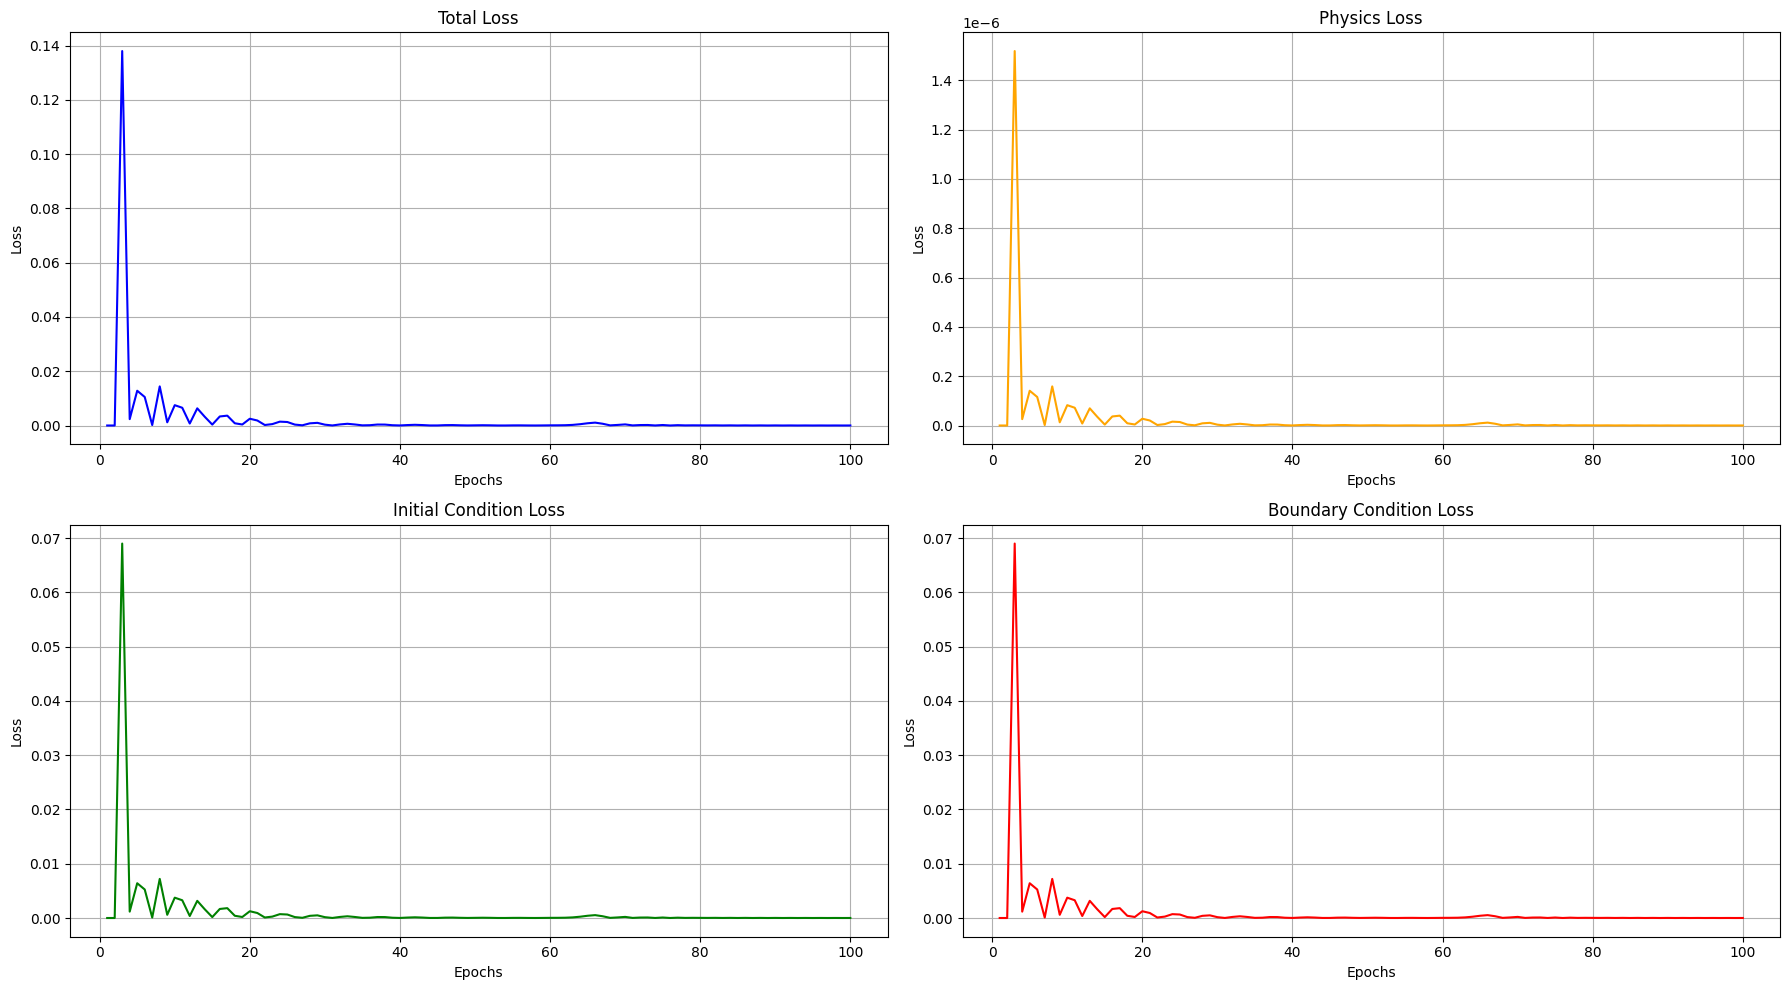

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

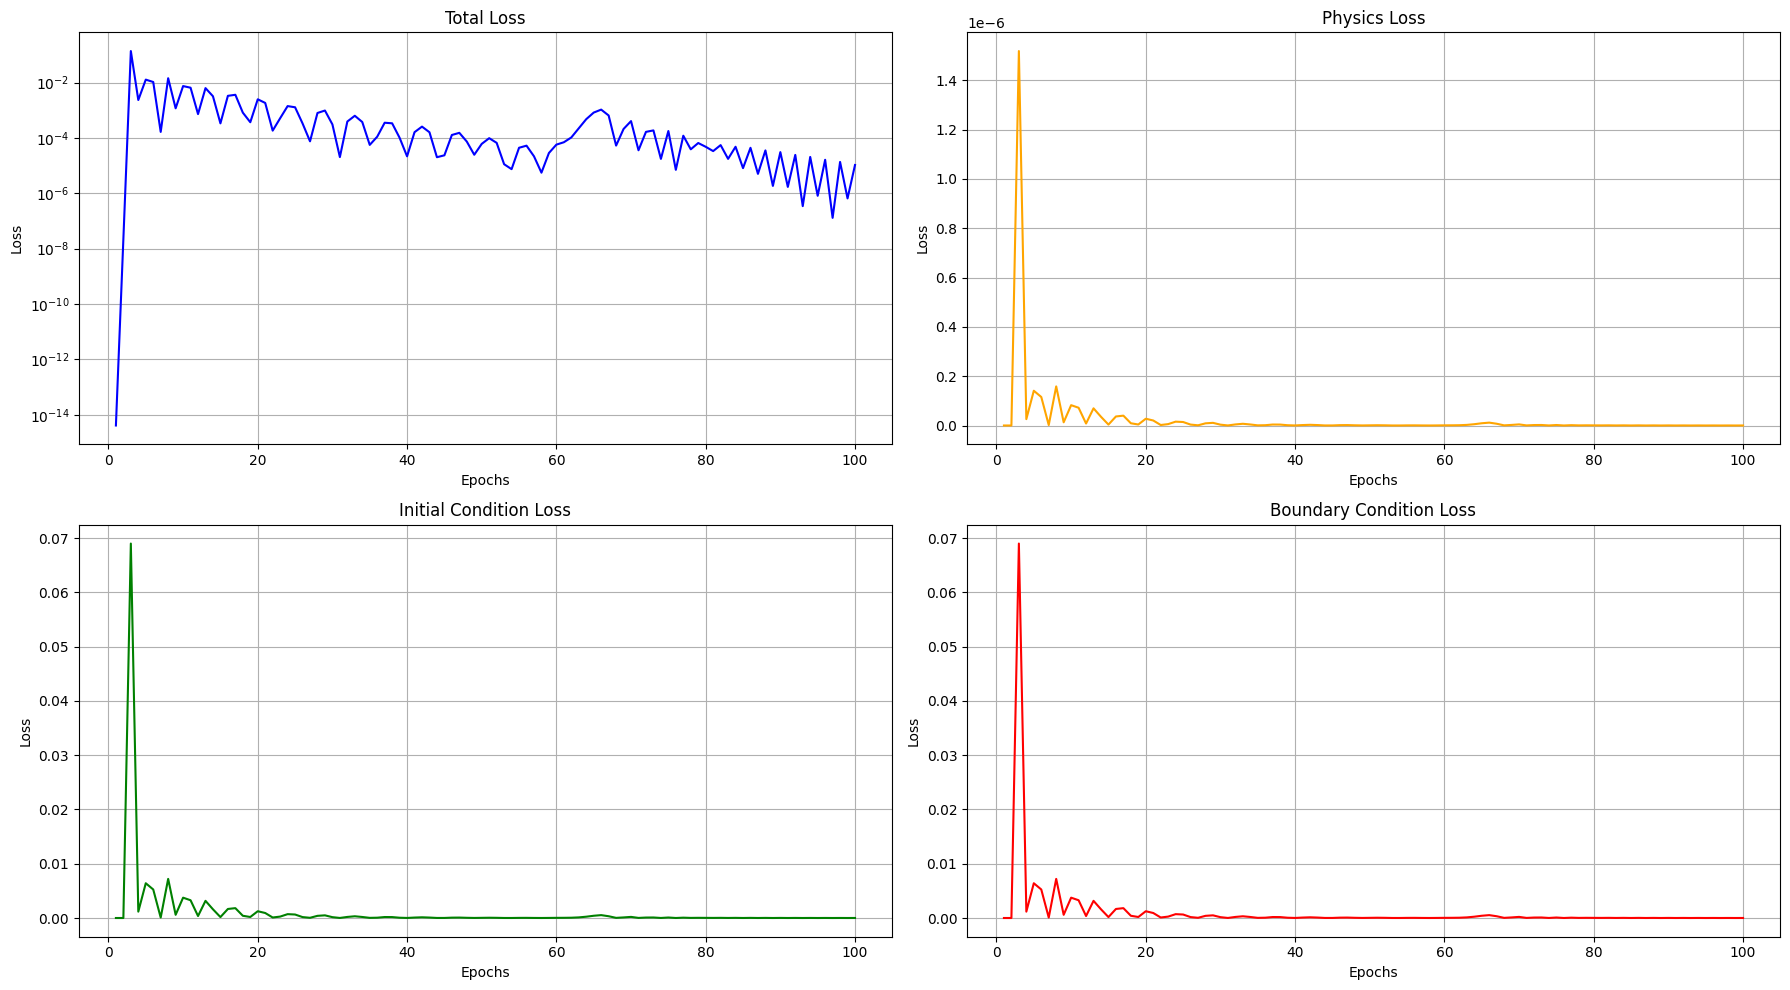

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 0].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[0, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[0, 0].set_yscale("log")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()